In [7]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


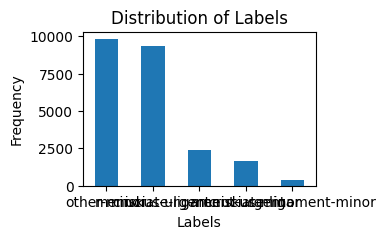

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [8]:
model_name = "lr_finder"

In [9]:
from utils import get_standard_parameters

optimizer, loss, metrics, earlystopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

In [21]:
import math
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import numpy as np

from tensorflow.keras.callbacks import LambdaCallback

class LRFinder:
    """
    Learning rate range test detailed in Cyclical Learning Rates for Training
    Neural Networks by Leslie N. Smith. The learning rate range test is a test
    that provides valuable information about the optimal learning rate. During
    a pre-training run, the learning rate is increased linearly or
    exponentially between two boundaries. The low initial learning rate allows
    the network to start converging and as the learning rate is increased it
    will eventually be too large and the network will diverge.
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.learning_rates = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        lr = float(K.get_value(self.model.optimizer.learning_rate))
        self.learning_rates.append(lr)

        loss = logs['loss']
        self.losses.append(loss)

        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, train_padded, train_labels, start_lr, end_lr, epochs=1,
             steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            raise Exception('To correctly train on the datagenerator,'
                            '`steps_per_epoch` cannot be None.'
                            'You can calculate it as '
                            '`np.ceil(len(TRAINING_LIST) / BATCH)`')

        self.lr_mult = (float(end_lr) /
                        float(start_lr)) ** (float(1) /
                                             float(epochs * steps_per_epoch))
        initial_weights = self.model.get_weights()

        original_lr = float(K.get_value(self.model.optimizer.learning_rate))
        K.set_value(self.model.optimizer.learning_rate, float(start_lr))

        callback = LambdaCallback(on_batch_end=lambda batch,
                                  logs: self.on_batch_end(batch, logs))

        self.model.fit(train_padded, train_labels,
                       epochs=epochs, callbacks=[callback], steps_per_epoch=steps_per_epoch, **kw_fit)
        self.model.set_weights(initial_weights)

        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def get_learning_rates(self):
        return self.learning_rates

    def get_losses(self):
        return self.losses

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.learning_rates)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.learning_rates[n_skip_beginning:-n_skip_end][best_der_idx]


# Model definition and training

In [15]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [16]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[lr_finder])

AttributeError: 'LRFinder' object has no attribute 'set_model'

In [22]:
STEPS_PER_EPOCH = np.ceil(len(train_padded) / batch_size)
lr_finder = LRFinder(model)
lr_finder.find(train_padded, train_labels, start_lr=1e-6, end_lr=1, epochs=5,
               steps_per_epoch=STEPS_PER_EPOCH)

AttributeError: 'str' object has no attribute 'name'

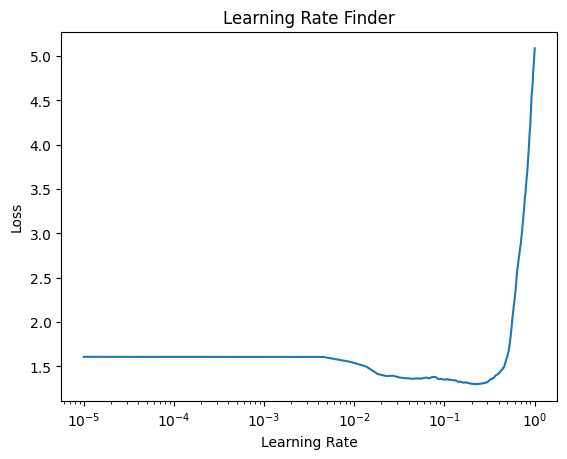

In [23]:
import matplotlib.pyplot as plt

def plot_loss(n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    """
    Plots the loss.
    Parameters:
        n_skip_beginning - number of batches to skip on the left.
        n_skip_end - number of batches to skip on the right.
        """
    learning_rates = lr_finder.get_learning_rates()
    losses = lr_finder.get_losses()

    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

In [24]:
axs = plot_loss()
axs.axvline(x=lr_finder.get_best_lr(sma=20), c='r', linestyle='-.')

1.009972758152174


In [12]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.08), loss=loss, metrics=metrics)

In [13]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[earlystopping_callback])

Epoch 1/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 116s 154ms/step - accuracy: 0.2301 - auc: 0.5888 - f1_score: 0.1290 - loss: 1.3578 - val_accuracy: 0.4169 - val_auc: 0.7769 - val_f1_score: 0.1177 - val_loss: 1.3595
Epoch 2/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 113s 154ms/step - accuracy: 0.4028 - auc: 0.7687 - f1_score: 0.1872 - loss: 1.3451 - val_accuracy: 0.3981 - val_auc: 0.7552 - val_f1_score: 0.2010 - val_loss: 1.4288
Epoch 3/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 113s 153ms/step - accuracy: 0.3864 - auc: 0.7379 - f1_score: 0.1986 - loss: 1.6566 - val_accuracy: 0.3442 - val_auc: 0.7123 - val_f1_score: 0.1732 - val_loss: 1.5011
Epoch 4/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 110s 149ms/step - accuracy: 0.3845 - auc: 0.7462 - f1_score: 0.1966 - loss: 1.5251 - val_accuracy: 0.4010 - val_auc: 0.7696 - val_f1_score: 0.1281 - val_loss: 1.6784
Epoch 5/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 110s 150ms/step - accuracy: 0.1450 - auc: 0.5523 - f1_score: 0.0901 - loss: nan - val_accuracy: 0.0150 - val_auc: 0.5000 - val_f1_score:

In [14]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to ../models/lstm/lr_finder/lr_finder.h5
Data saved


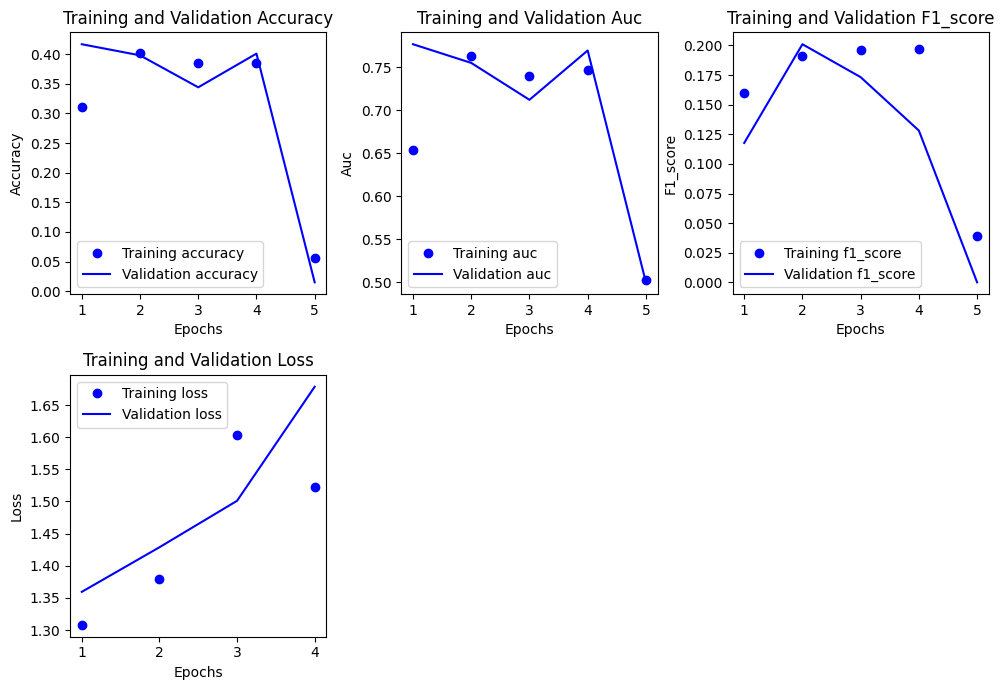

In [15]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step


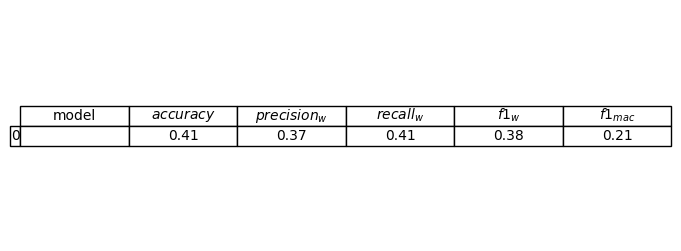

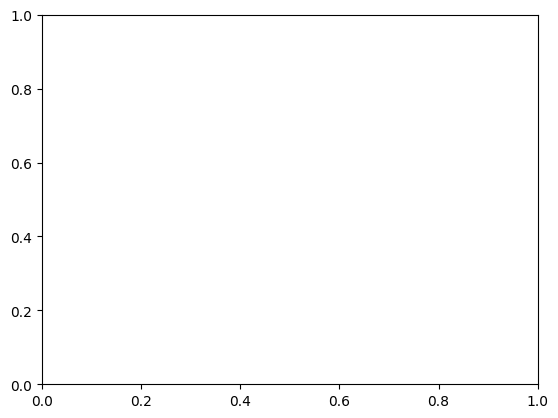

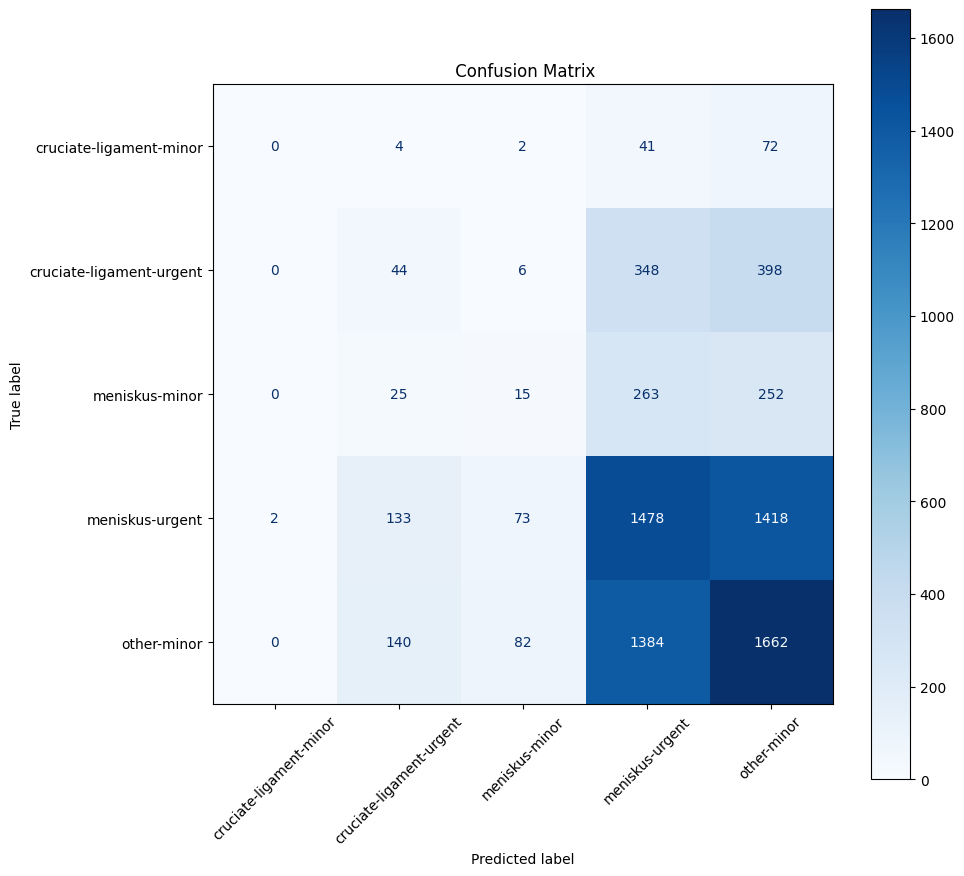

,model,$accuracy$,$precision_{w}$,$recall_{w}$,$f1_{w}$,$f1_{mac}$
0,,0.41,0.37,0.41,0.38,0.21


In [16]:
eval(model, test_padded, test_labels, label_encoder)